In [1]:
# Import libraries
import os
import shutil
import random
from PIL import Image
from tqdm import tqdm


In [2]:
# Define parameters
original_data_path = 'C:/Users/user/Jupyter/fruit-veg-freshness-detector/data/raw/Fruit And Vegetable Diseases Dataset/'
processed_data_path = 'C:/Users/user/Jupyter/fruit-veg-freshness-detector/data/processed/'
img_size = (224, 224)  # You can change this to (256, 256) or (128, 128)
split_ratio = (0.7, 0.15, 0.15)  # Train, Validation, Test


In [3]:
# Create directory structure
splits = ['train', 'val', 'test']
class_dirs = sorted(os.listdir(original_data_path))

# Create folders
for split in splits:
    for class_dir in class_dirs:
        os.makedirs(os.path.join(processed_data_path, split, class_dir), exist_ok=True)


In [4]:
# Resize images and split data
for class_dir in tqdm(class_dirs, desc="Processing classes"):
    source_dir = os.path.join(original_data_path, class_dir)
    images = os.listdir(source_dir)
    random.shuffle(images)

    train_end = int(split_ratio[0] * len(images))
    val_end = train_end + int(split_ratio[1] * len(images))

    split_images = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split in splits:
        for img_name in split_images[split]:
            img_path = os.path.join(source_dir, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                target_path = os.path.join(processed_data_path, split, class_dir, img_name)
                img.save(target_path)
            except Exception as e:
                print(f"Error with {img_path}: {e}")


Processing classes:  79%|████████████████████████████████████████████████▋             | 22/28 [23:53<06:57, 69.55s/it]C:\Users\user\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Processing classes: 100%|██████████████████████████████████████████████████████████████| 28/28 [26:04<00:00, 55.87s/it]


In [6]:
# Load and augment dataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Paths
data_dir = 'C:/Users/user/Jupyter/fruit-veg-freshness-detector/data/processed/'

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_val_test)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_val_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class mapping
print(train_dataset.class_to_idx)


{'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'Grape__Healthy': 10, 'Grape__Rotten': 11, 'Guava__Healthy': 12, 'Guava__Rotten': 13, 'Jujube__Healthy': 14, 'Jujube__Rotten': 15, 'Mango__Healthy': 16, 'Mango__Rotten': 17, 'Orange__Healthy': 18, 'Orange__Rotten': 19, 'Pomegranate__Healthy': 20, 'Pomegranate__Rotten': 21, 'Potato__Healthy': 22, 'Potato__Rotten': 23, 'Strawberry__Healthy': 24, 'Strawberry__Rotten': 25, 'Tomato__Healthy': 26, 'Tomato__Rotten': 27}


In [7]:
# Define CNN

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 224 → 112
        x = self.pool(F.relu(self.conv2(x)))  # 112 → 56
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [8]:
# Training utilities
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

        # Evaluate on validation set
        val_acc = evaluate_model(model, val_loader, device)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"✅ Best model saved with val acc: {val_acc:.4f}")

    print("Training complete.")

def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Datasets and loaders
data_path = 'C:/Users/user/Jupyter/fruit-veg-freshness-detector/data/processed/'
train_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=transform_train)
val_dataset   = datasets.ImageFolder(os.path.join(data_path, 'val'), transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)

# Model, Loss, Optimizer
model = SimpleCNN(num_classes=len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)


Epoch 1/10 - Loss: 2.0760 - Acc: 0.3889
✅ Best model saved with val acc: 0.5640
Epoch 2/10 - Loss: 1.3298 - Acc: 0.5882
✅ Best model saved with val acc: 0.6814
Epoch 3/10 - Loss: 1.0797 - Acc: 0.6627
✅ Best model saved with val acc: 0.7318
Epoch 4/10 - Loss: 0.9282 - Acc: 0.7078
✅ Best model saved with val acc: 0.7733
Epoch 5/10 - Loss: 0.8195 - Acc: 0.7426
✅ Best model saved with val acc: 0.7831
Epoch 6/10 - Loss: 0.7449 - Acc: 0.7671
✅ Best model saved with val acc: 0.8000
Epoch 7/10 - Loss: 0.6668 - Acc: 0.7900
✅ Best model saved with val acc: 0.8084
Epoch 8/10 - Loss: 0.6077 - Acc: 0.8070
✅ Best model saved with val acc: 0.8180
Epoch 9/10 - Loss: 0.5482 - Acc: 0.8263
✅ Best model saved with val acc: 0.8456
Epoch 10/10 - Loss: 0.4966 - Acc: 0.8423
✅ Best model saved with val acc: 0.8465
Training complete.


In [10]:
# Libraries for model metric
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [11]:
# Evaluate on test data

def evaluate_with_metrics(model, test_loader, class_names, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-score: {f1:.4f}")
    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return y_true, y_pred


In [12]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


✅ Accuracy: 0.8385
✅ Precision: 0.8381
✅ Recall: 0.8385
✅ F1-score: 0.8371

📋 Classification Report:
                      precision    recall  f1-score   support

      Apple__Healthy       0.87      0.89      0.88       367
       Apple__Rotten       0.89      0.84      0.86       440
     Banana__Healthy       0.90      0.90      0.90       300
      Banana__Rotten       0.92      0.94      0.93       421
 Bellpepper__Healthy       0.77      0.84      0.80        93
  Bellpepper__Rotten       0.48      0.33      0.39        90
     Carrot__Healthy       0.75      0.83      0.79        93
      Carrot__Rotten       0.59      0.52      0.55        87
   Cucumber__Healthy       0.88      0.75      0.81        92
    Cucumber__Rotten       0.82      0.74      0.78        90
      Grape__Healthy       0.85      0.73      0.79        30
       Grape__Rotten       0.82      0.93      0.88        30
      Guava__Healthy       0.82      0.93      0.88        30
       Guava__Rotten       0.7

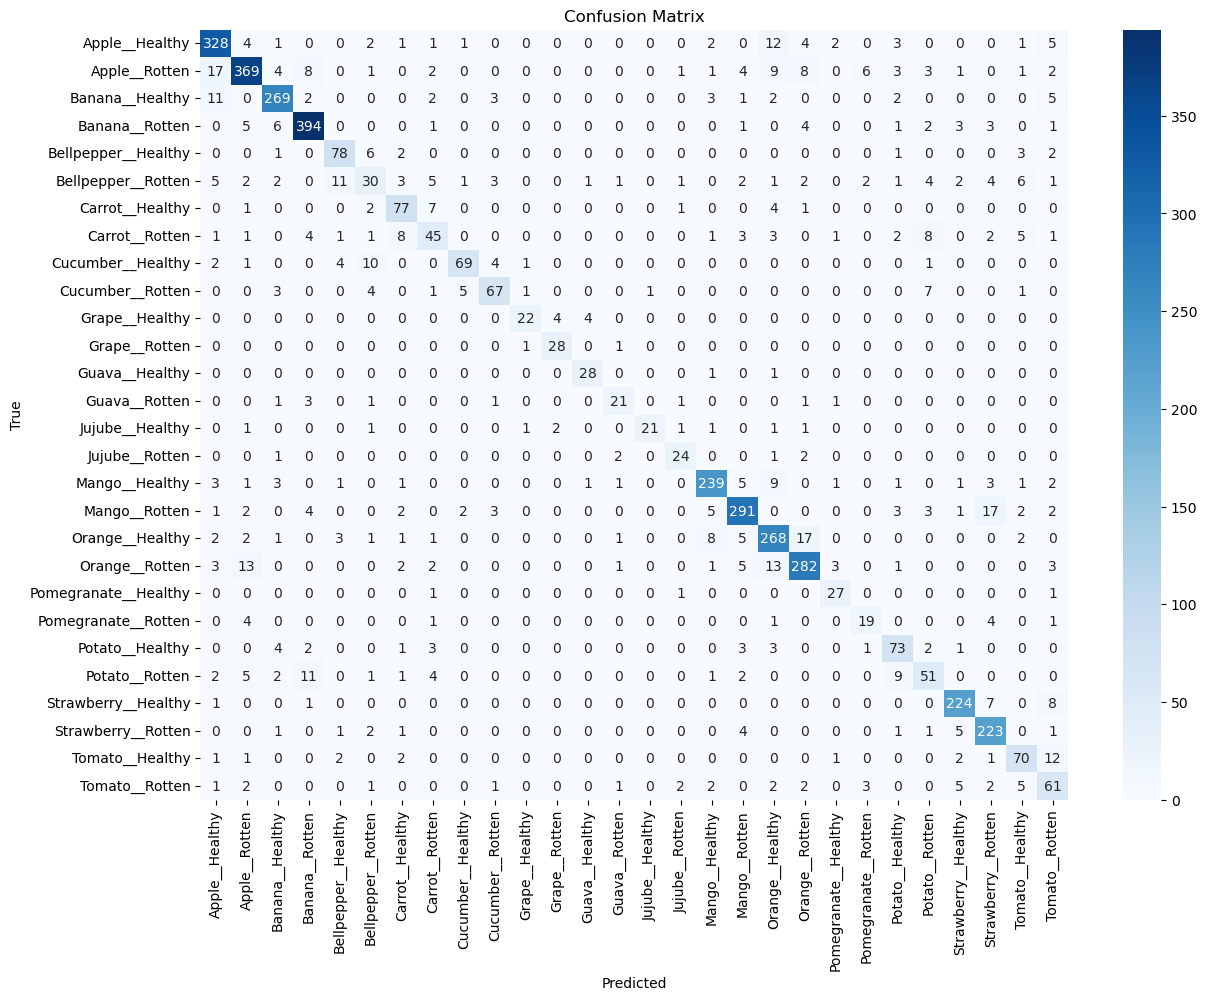

In [13]:
y_true, y_pred = evaluate_with_metrics(model, test_loader, class_names=train_dataset.classes, device=device)
plot_confusion_matrix(y_true, y_pred, train_dataset.classes)
